In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

In [26]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = pd.read_csv(data)

In [20]:
df = df[[
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


EDA
###### Look at the fuel_efficiency_mpg variable. Does it have a long tail?

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

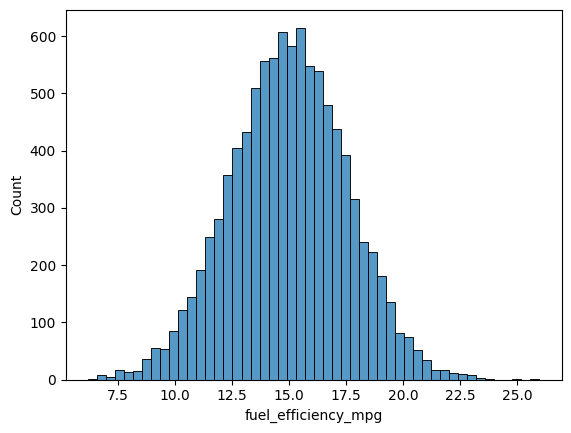

In [24]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

No, fuel_efficiency_mpg variable doesnt have a long tail


Question 1

There's one column with missing values. What is it?

    'engine_displacement'
    'horsepower'
    'vehicle_weight'
    'model_year'


In [25]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Question 2

What's the median (50% percentile) for variable 'horsepower'?

In [28]:
df['horsepower'].describe().round(1)

count    8996.0
mean      149.7
std        29.9
min        37.0
25%       130.0
50%       149.0
75%       170.0
max       271.0
Name: horsepower, dtype: float64

Prepare and split the dataset

    Shuffle the dataset (the filtered one you created above), use seed 42.
    Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [43]:
n = len(df)
n

9704

In [44]:
indices = np.arange(n)
indices

array([   0,    1,    2, ..., 9701, 9702, 9703], shape=(9704,))

In [45]:
np.random.seed(42)
np.random.shuffle(indices)
indices

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

shuffled

In [46]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

n, n_test + n_val + n_train # test the same rows to make sure

(9704, 9704)

In [48]:
df_train = df.iloc[indices[ : n_train]]
df_val = df.iloc[indices[n_train : n_train + n_val]] 
df_test = df.iloc[indices[n_train + n_val :]]

In [49]:
# check each part
n_test, n_train, n_val

(1940, 5824, 1940)

Question 3

    We need to deal with missing values for the column from Q1.
    We have two options: fill it with 0 or with the mean of this variable.
    Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    For computing the mean, use the training only!
    Use the validation dataset to evaluate the models and compare the RMSE of each option.
    Round the RMSE scores to 2 decimal digits using round(score, 2)
    Which option gives better RMSE?


In [56]:
feature = 'horsepower'
target = 'fuel_efficiency_mpg'

y_train = df_train[target].values
y_val = df_val[target].values

# Option 1: Fill missing with 0
X_train_0 = df_train[[feature]].fillna(0).values
X_val_0 = df_val[[feature]].fillna(0).values

# Linear Regression (normal equation)
def train_linear_regression(X, y):
    X = np.array(X)
    y = np.array(y)
    ones = np.ones((X.shape[0], 1))
    X = np.hstack([ones, X])
    w_full = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    return w_full[0], w_full[1:]

w0_0, w_0 = train_linear_regression(X_train_0, y_train)

# Predict
y_pred_val_0 = w0_0 + X_val_0.dot(w_0)

# RMSE
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

rmse_0 = round(rmse(y_val, y_pred_val_0), 2)
print("RMSE fill 0:", rmse_0)


# Option 2: Fill missing with mean of train
mean_hp = np.nanmean(df_train[feature])
X_train_mean = df_train[[feature]].fillna(mean_hp).values
X_val_mean = df_val[[feature]].fillna(mean_hp).values

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_val_mean = w0_mean + X_val_mean.dot(w_mean)
rmse_mean = round(rmse(y_val, y_pred_val_mean), 2)
print("RMSE fill mean:", rmse_mean)


RMSE fill 0: 2.65
RMSE fill mean: 2.64


Question 4

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?


In [59]:
# fill missing with 0
X_train = df_train[[feature]].fillna(0).values
X_val = df_val[[feature]].fillna(0).values

# linear Regression function with regularization
def train_linear_regression_reg(X, y, r=0.0):
    X = np.array(X)
    y = np.array(y)
    
    # add column 1 for bias
    ones = np.ones((X.shape[0], 1))
    X = np.hstack([ones, X])
    
    XTX = X.T.dot(X)
    XTX += r * np.eye(XTX.shape[0])  # regularization
    w_full = np.linalg.pinv(XTX).dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# list r value
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

best_rmse = float('inf')
best_r = None

for r in r_list:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred_val = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred_val), 2)
    print(f"r={r}, RMSE={score}")
    
    # save the best value
    if score < best_rmse or (score == best_rmse and r < best_r):
        best_rmse = score
        best_r = r

print(f"\nBest r: {best_r} with RMSE: {best_rmse}")

r=0, RMSE=2.65
r=0.01, RMSE=2.65
r=0.1, RMSE=2.65
r=1, RMSE=2.65
r=5, RMSE=2.65
r=10, RMSE=2.65
r=100, RMSE=2.73

Best r: 0 with RMSE: 2.65


Question 5

    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    Fill the missing values with 0 and train a model without regularization.
    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    Round the result to 3 decimal digits (round(std, 3))


In [60]:
seeds = list(range(10))
rmse_list = []

for seed in seeds:
    # shuffle indices
    np.random.seed(seed)
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    
    # split sizes
    n = len(df)
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    n_test = n - n_train - n_val
    
    # split dataframe
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)
    
    # prepare X
    X_train = df_train[[feature]].fillna(0).values
    X_val = df_val[[feature]].fillna(0).values
    
    # train linear regression
    w0, w = train_linear_regression(X_train, y_train)
    
    # predict on validation
    y_pred_val = w0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred_val)
    rmse_list.append(rmse_val)

# standard deviation of RMSEs
std_rmse = round(np.std(rmse_list), 3)
print("RMSE for each seed:", rmse_list)
print("Standard deviation of RMSEs:", std_rmse)


RMSE for each seed: [np.float64(2.6547506716440368), np.float64(2.6538455698673324), np.float64(2.6544361833959753), np.float64(2.6534757751332423), np.float64(2.654496666830574), np.float64(2.653953145255802), np.float64(2.655168959439953), np.float64(2.6534743525592512), np.float64(2.653779555357022), np.float64(2.6543157925900758)]
Standard deviation of RMSEs: 0.001


Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?


In [63]:
# shuffle with seed 9
np.random.seed(9)
idx = np.arange(len(df))
np.random.shuffle(idx)

n = len(df)
n_train = int(n * 0.6)
n_val   = int(n * 0.2)
n_test  = n - n_train - n_val 

# split dataset
df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val   = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test  = df.iloc[idx[n_train+n_val:n_train+n_val+n_test]].reset_index(drop=True)

# target (y)
y_train = df_train.fuel_efficiency_mpg.values
y_val   = df_val.fuel_efficiency_mpg.values
y_test  = df_test.fuel_efficiency_mpg.values

# combine train + validation
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# prepare X
X_full_train = df_full_train[[feature]].fillna(0).values
X_test       = df_test[[feature]].fillna(0).values

# train regularized linear regression function
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones((X.shape[0], 1))
    X = np.hstack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

# rmse function
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

# train model
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# predict & calculate rmse in test set
y_pred_test = w0 + X_test.dot(w)
score_test = round(rmse(y_test, y_pred_test), 2)
print("RMSE on test set:", score_test)

RMSE on test set: 2.55
